In [1]:
import numpy as np
import scipy.io


m = scipy.io.loadmat('BCICIV_calib_ds1a.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)
EEG.shape

(59, 190594)

In [2]:
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2


In [3]:
import numpy as np

samples = EEG
labeled_indices = np.array(event_onsets).flatten()
labels = np.array(event_codes).flatten()


print(f"Samples shape: {samples.shape}")
print(f"Labeled indices: {labeled_indices}")
print(f"Labels: {labels}")

def create_windows(data, indices, labels, window_size=800):
    windows = []
    window_labels = []
    for idx, label in zip(indices, labels):
        idx = int(idx)
        if idx + window_size <= data.shape[1]:
            window = data[:, idx: idx + window_size]
            windows.append(window)
            window_labels.append(label)
        else:
            print(f"Index {idx} is too close to the end of the data, skipping.")
    return np.array(windows), np.array(window_labels)

windows, window_labels = create_windows(samples, labeled_indices, labels)

print(f"Shape of windows array: {windows.shape}")

total_windows = len(windows)
print(f"Total windows created: {total_windows}")

class_0_windows = windows[window_labels == -1]  # 0-->-1
class_1_windows = windows[window_labels == 1]

print(f"Shape of class 0 windows: {class_0_windows.shape}")
print(f"Shape of class 1 windows: {class_1_windows.shape}")

print(f"Total windows for class 0: {len(class_0_windows)}")
print(f"Total windows for class 1: {len(class_1_windows)}")

Samples shape: (59, 190594)
Labeled indices: [  2091   2891   3691   4491   5291   6091   6891   7692   8492   9292
  10092  10892  11692  12492  13292  16294  17094  17894  18694  19494
  20294  21094  21894  22694  23494  24294  25094  25894  26694  27494
  30495  31295  32095  32895  33695  34495  35295  36095  36895  37695
  38495  39295  40095  40895  41695  44696  45496  46296  47096  47896
  48696  49496  50296  51096  51896  52696  53496  54296  55096  55896
  58895  59695  60495  61295  62095  62895  63695  64495  65295  66095
  66895  67695  68495  69295  70095  73094  73894  74694  75495  76295
  77095  77895  78695  79495  80295  81095  81895  82695  83495  84295
  87294  88094  88894  89694  90494  91294  92094  92894  93694  94494
  97385  98185  98985  99785 100585 101385 102185 102985 103785 104585
 105385 106185 106985 107785 108585 111584 112384 113184 113984 114784
 115584 116384 117184 117984 118785 119585 120385 121185 121985 122785
 125787 126587 127387 128187 128

In [4]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def apply_bandpass_filter(window, fs=100, lowcut=8, highcut=30, order=3):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_window = sosfiltfilt(sos, window, axis=-1)
    return filtered_window

filtered_class_0_windows = []
for window in class_0_windows:
    filtered_window = apply_bandpass_filter(window)
    filtered_class_0_windows.append(filtered_window)

filtered_class_0_windows = np.array(filtered_class_0_windows)

filtered_class_1_windows = []
for window in class_1_windows:
    filtered_window = apply_bandpass_filter(window)
    filtered_class_1_windows.append(filtered_window)

filtered_class_1_windows = np.array(filtered_class_1_windows)

print(f"Shape of filtered class 0 windows: {filtered_class_0_windows.shape}")
print(f"Shape of filtered class 1 windows: {filtered_class_1_windows.shape}")

Shape of filtered class 0 windows: (100, 59, 800)
Shape of filtered class 1 windows: (100, 59, 800)


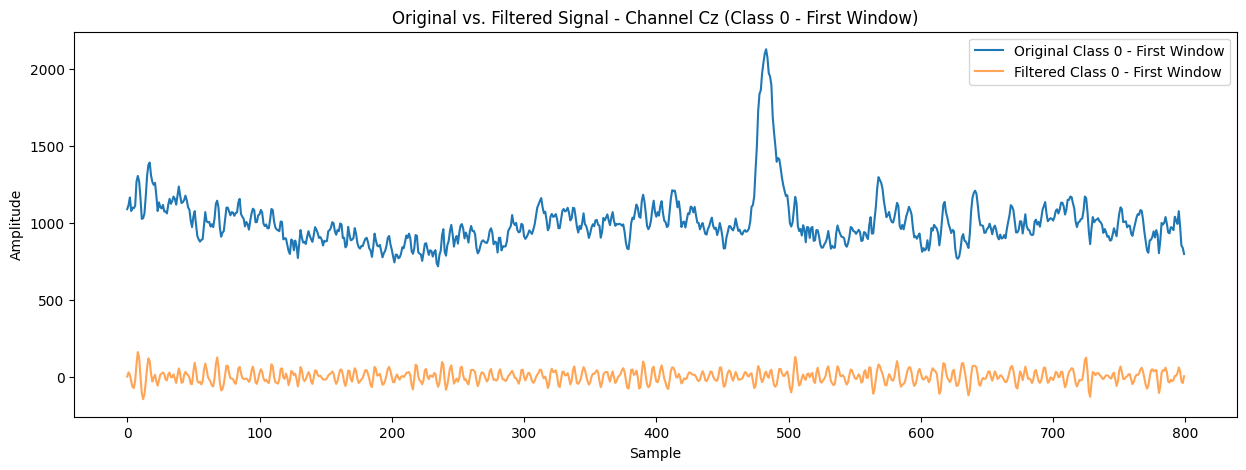

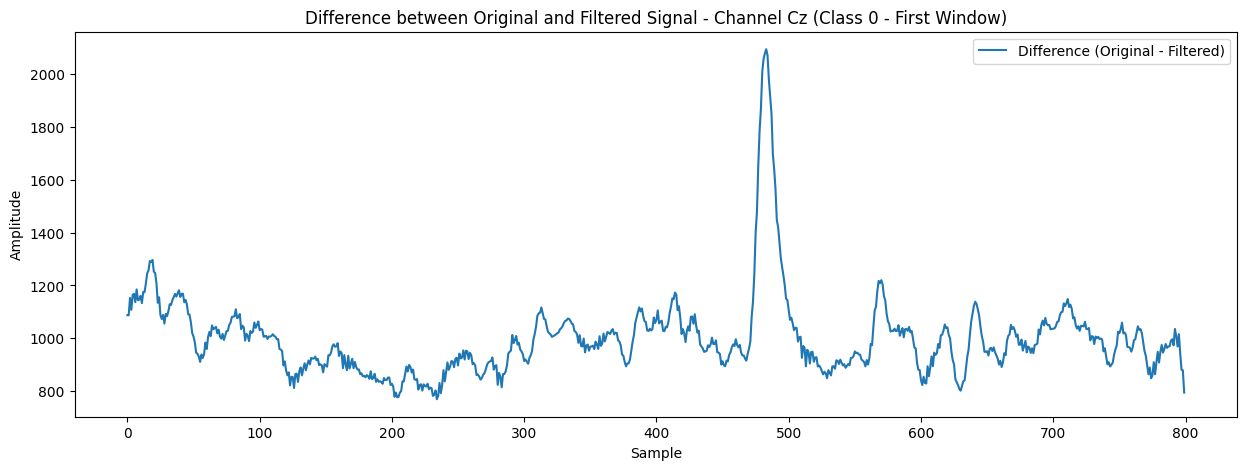

Mean Squared Error (MSE) between original and filtered signals: 1019847.7356


In [5]:
import numpy as np
import matplotlib.pyplot as plt

first_window_class_0 = class_0_windows[0]
first_window_filtered_class_0 = filtered_class_0_windows[0]

channel_index = 10

plt.figure(figsize=(15, 5))
plt.plot(first_window_class_0[channel_index, :], label='Original Class 0 - First Window')
plt.plot(first_window_filtered_class_0[channel_index, :], label='Filtered Class 0 - First Window', alpha=0.7)
plt.title('Original vs. Filtered Signal - Channel Cz (Class 0 - First Window)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

difference = first_window_class_0[channel_index, :] - first_window_filtered_class_0[channel_index, :]
plt.figure(figsize=(15, 5))
plt.plot(difference, label='Difference (Original - Filtered)')
plt.title('Difference between Original and Filtered Signal - Channel Cz (Class 0 - First Window)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(first_window_class_0[channel_index, :], first_window_filtered_class_0[channel_index, :])
print(f"Mean Squared Error (MSE) between original and filtered signals: {mse:.4f}")

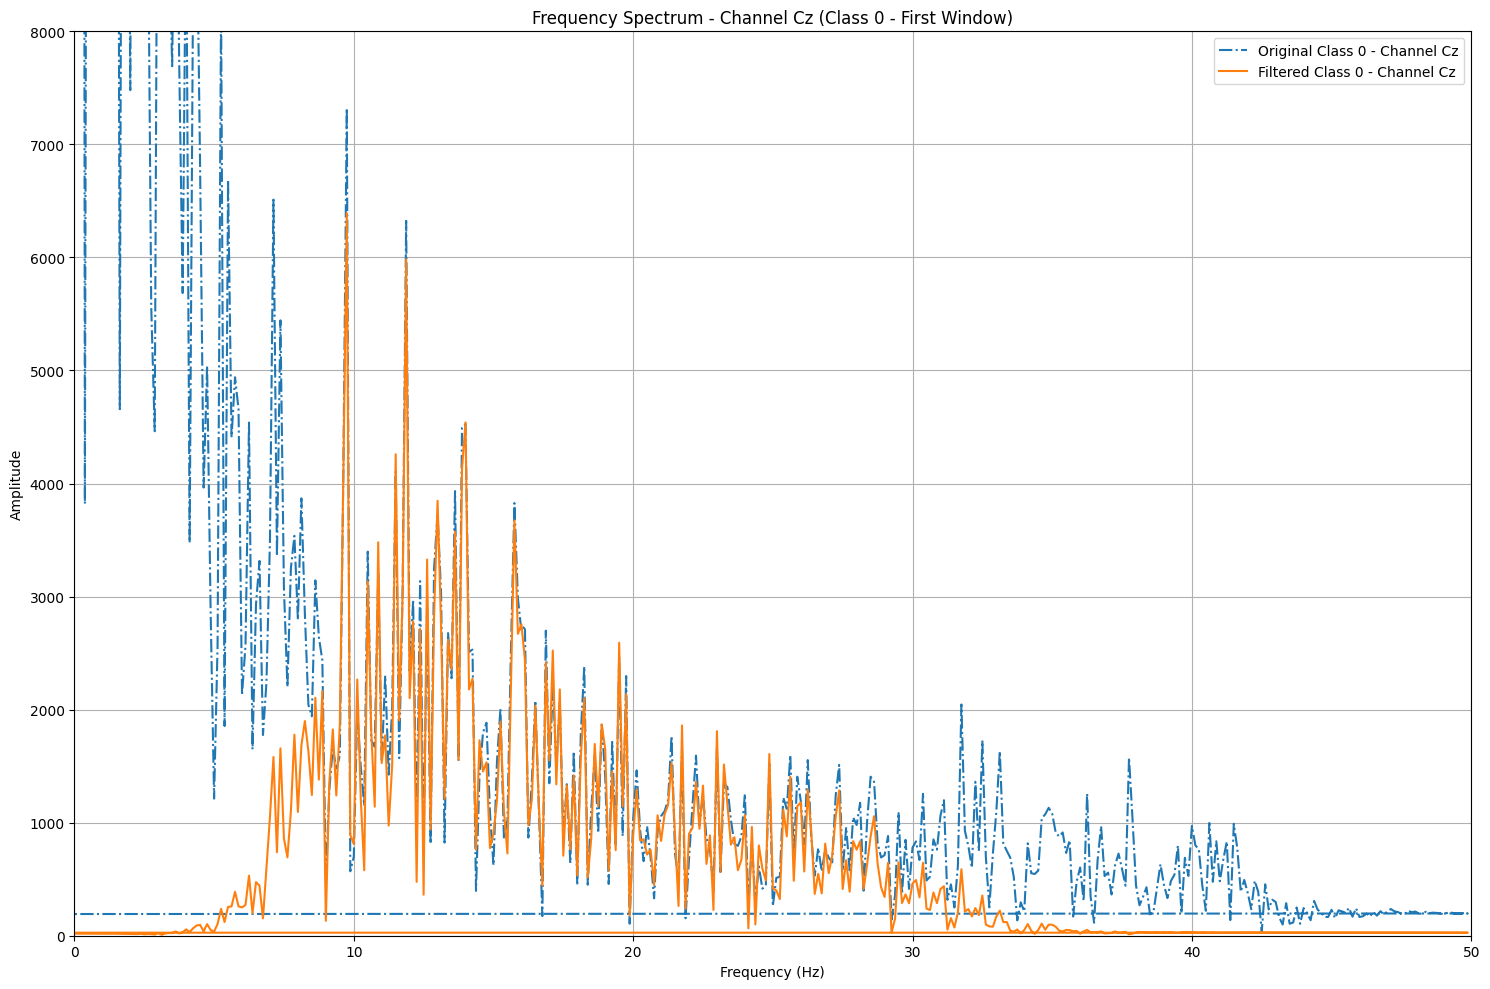

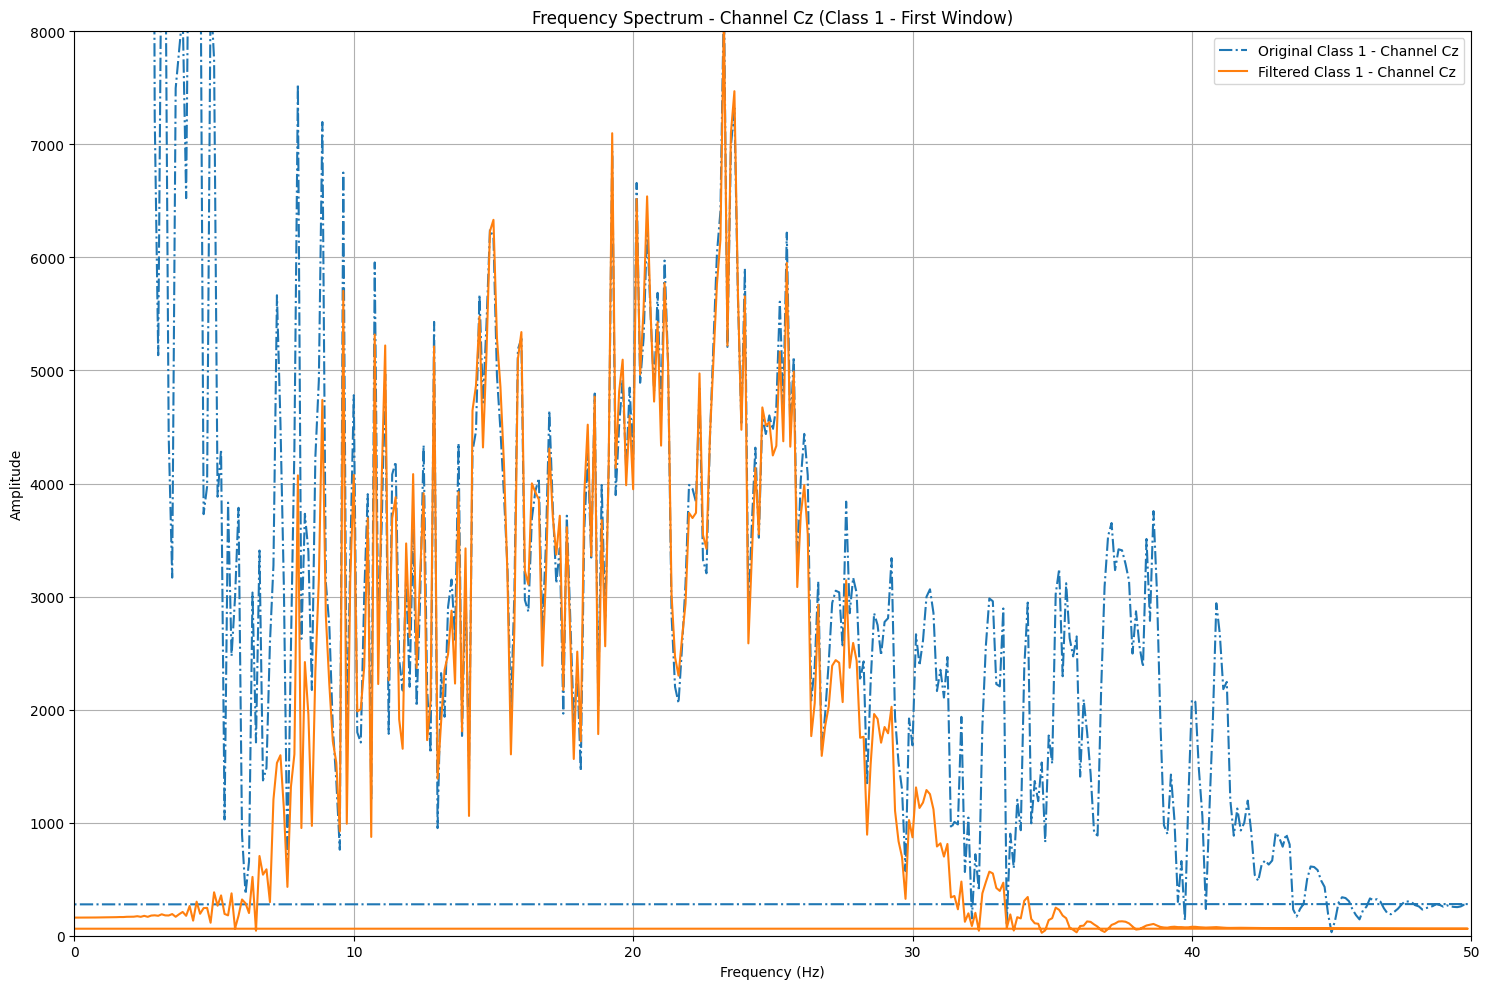

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

channel_index = 10

fs = 100
N = class_0_windows.shape[2]

yf_class_0_original = fft(class_0_windows[0, channel_index, :], axis=-1)
yf_class_0_filtered = fft(filtered_class_0_windows[0, channel_index, :], axis=-1)
yf_class_1_original = fft(class_1_windows[0, channel_index, :], axis=-1)
yf_class_1_filtered = fft(filtered_class_1_windows[0, channel_index, :], axis=-1)
xf = fftfreq(N, 1 / fs)

plt.figure(figsize=(15, 10))

plt.plot(xf, np.abs(yf_class_0_original), label='Original Class 0 - Channel Cz', linestyle='-.')
plt.plot(xf, np.abs(yf_class_0_filtered), label='Filtered Class 0 - Channel Cz', linestyle='-')

plt.title('Frequency Spectrum - Channel Cz (Class 0 - First Window)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.xlim(0, fs / 2)
plt.ylim(0, 8000)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

plt.plot(xf, np.abs(yf_class_1_original), label='Original Class 1 - Channel Cz', linestyle='-.')
plt.plot(xf, np.abs(yf_class_1_filtered), label='Filtered Class 1 - Channel Cz', linestyle='-')

plt.title('Frequency Spectrum - Channel Cz (Class 1 - First Window)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.xlim(0, fs / 2)
plt.ylim(0, 8000)

plt.tight_layout()
plt.show()

In [7]:
'''
import matplotlib.pyplot as plt
import numpy as np


windows = windows  # Example data, replace with your actual labeled windows

# Function to plot all labeled windows for all channels
def plot_labeled_windows(windows):
    num_windows = windows.shape[0]
    num_channels = windows.shape[1]
    time_samples = windows.shape[2]

    # Create a figure and axis
    fig, axs = plt.subplots(num_channels, 1, figsize=(12, 2*num_channels), sharex=True)

    # Iterate through each channel
    for channel in range(num_channels):
        axs[channel].set_ylabel(f'Channel {channel+1}')

        # Plot each window for this channel
        for window_idx in range(num_windows):
            axs[channel].plot(windows[window_idx, channel, :], alpha=0.5)

    # Set common labels and title
    axs[-1].set_xlabel('Time samples')
    fig.suptitle('Labeled EEG Data - All Channels')

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

# Call function to plot labeled windows
plot_labeled_windows(windows)
'''

"\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n\nwindows = windows  # Example data, replace with your actual labeled windows\n\n# Function to plot all labeled windows for all channels\ndef plot_labeled_windows(windows):\n    num_windows = windows.shape[0]\n    num_channels = windows.shape[1]\n    time_samples = windows.shape[2]\n\n    # Create a figure and axis\n    fig, axs = plt.subplots(num_channels, 1, figsize=(12, 2*num_channels), sharex=True)\n\n    # Iterate through each channel\n    for channel in range(num_channels):\n        axs[channel].set_ylabel(f'Channel {channel+1}')\n\n        # Plot each window for this channel\n        for window_idx in range(num_windows):\n            axs[channel].plot(windows[window_idx, channel, :], alpha=0.5)\n\n    # Set common labels and title\n    axs[-1].set_xlabel('Time samples')\n    fig.suptitle('Labeled EEG Data - All Channels')\n\n    # Adjust layout and display plot\n    plt.tight_layout()\n    plt.show()\n\n# Call function to

In [8]:
import numpy as np

laplacian_matrix = np.eye(59) * (-1)

def apply_laplacian_filter(window, laplacian_matrix):
    laplacian_filtered_window = np.dot(laplacian_matrix, window)
    return laplacian_filtered_window

laplacian_filtered_class_0_windows = np.array([apply_laplacian_filter(window, laplacian_matrix) for window in filtered_class_0_windows])
laplacian_filtered_class_1_windows = np.array([apply_laplacian_filter(window, laplacian_matrix) for window in filtered_class_1_windows])

print(f"Shape of Laplacian-filtered class 0 windows: {laplacian_filtered_class_0_windows.shape}")
print(f"Shape of Laplacian-filtered class 1 windows: {laplacian_filtered_class_1_windows.shape}")

Shape of Laplacian-filtered class 0 windows: (100, 59, 800)
Shape of Laplacian-filtered class 1 windows: (100, 59, 800)


**Comparing before and after filtering**

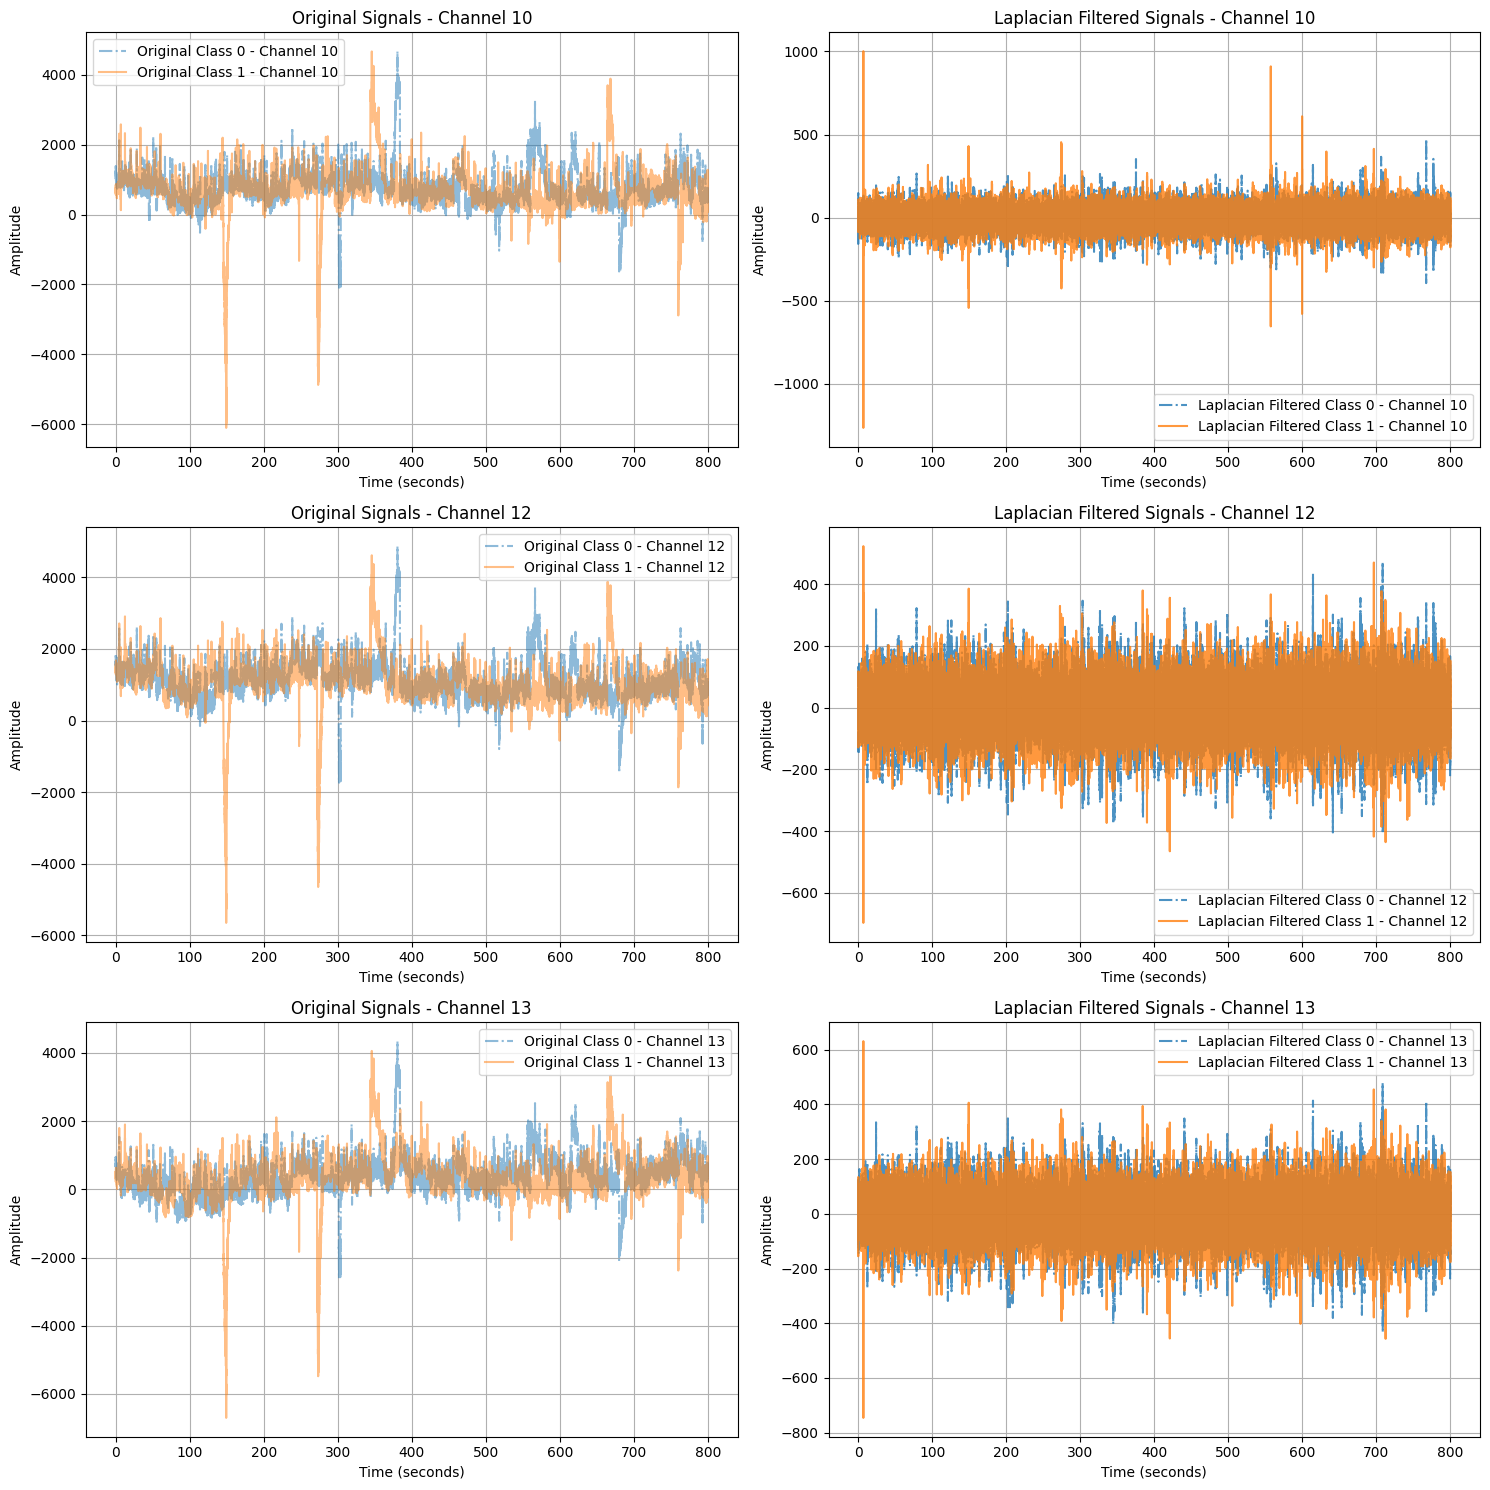

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Select channels of interest: CZ, C3, C4
channels_of_interest = [10, 12, 13]

fs = 100
window_size = 800
total_windows = 100

time = np.arange(0, total_windows * window_size) / fs
def concatenate_windows(windows, channel_index):
    return np.concatenate(windows[:, channel_index, :], axis=-1)

plt.figure(figsize=(15, 15))

for idx, channel_idx in enumerate(channels_of_interest):
    concatenated_class_0_original = concatenate_windows(class_0_windows, channel_idx)
    concatenated_class_1_original = concatenate_windows(class_1_windows, channel_idx)
    concatenated_class_0_laplacian = concatenate_windows(laplacian_filtered_class_0_windows, channel_idx)
    concatenated_class_1_laplacian = concatenate_windows(laplacian_filtered_class_1_windows, channel_idx)

    plt.subplot(len(channels_of_interest), 2, 2 * idx + 1)
    plt.plot(time, concatenated_class_0_original, label=f'Original Class 0 - Channel {channel_idx}', linestyle='-.', alpha=0.5)
    plt.plot(time, concatenated_class_1_original, label=f'Original Class 1 - Channel {channel_idx}', linestyle='-', alpha=0.5)
    plt.title(f'Original Signals - Channel {channel_idx}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

    plt.subplot(len(channels_of_interest), 2, 2 * idx + 2)
    plt.plot(time, concatenated_class_0_laplacian, label=f'Laplacian Filtered Class 0 - Channel {channel_idx}', linestyle='-.', alpha=0.8)
    plt.plot(time, concatenated_class_1_laplacian, label=f'Laplacian Filtered Class 1 - Channel {channel_idx}', linestyle='-', alpha=0.8)
    plt.title(f'Laplacian Filtered Signals - Channel {channel_idx}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


**t_SNE**

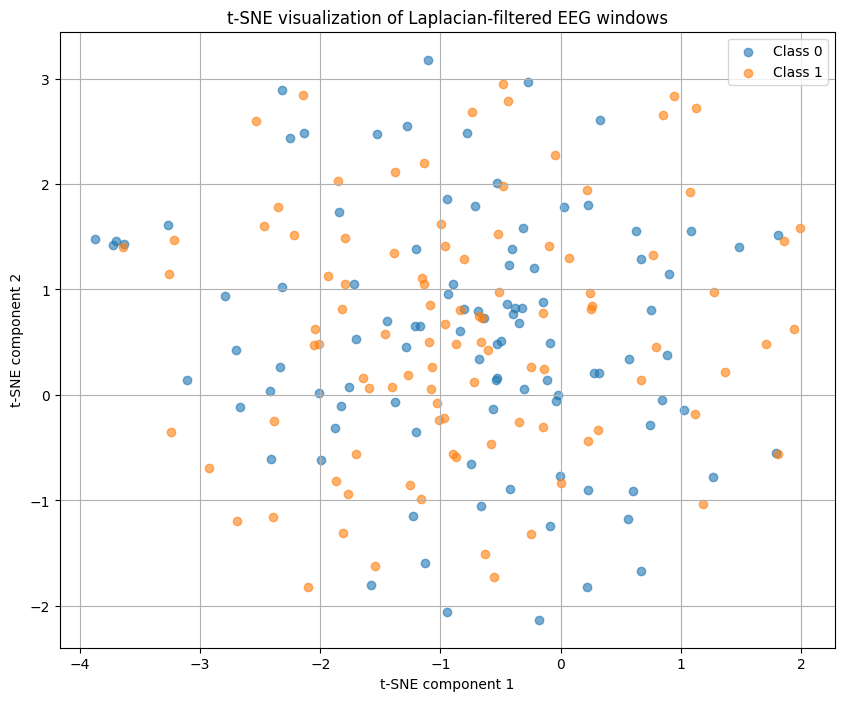

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_class_0 = laplacian_filtered_class_0_windows.reshape(100, -1)
X_class_1 = laplacian_filtered_class_1_windows.reshape(100, -1)

X = np.concatenate((X_class_0, X_class_1), axis=0)
y = np.concatenate((np.ones(100)*(-1), np.ones(100)))

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[y == -1, 0], X_tsne[y == -1, 1], label='Class 0', alpha=0.6)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='Class 1', alpha=0.6)
plt.title('t-SNE visualization of Laplacian-filtered EEG windows')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
!pip install mne


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.8 MB/s eta 0:00:00


**CSP**

**Logistic** **Regression**

In [12]:
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

class_0_data = laplacian_filtered_class_0_windows
class_1_data = laplacian_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

num_components = 16
csp = CSP(n_components=num_components, reg=None, log=True, norm_trace=False)

X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.


Accuracy on test set: 0.82


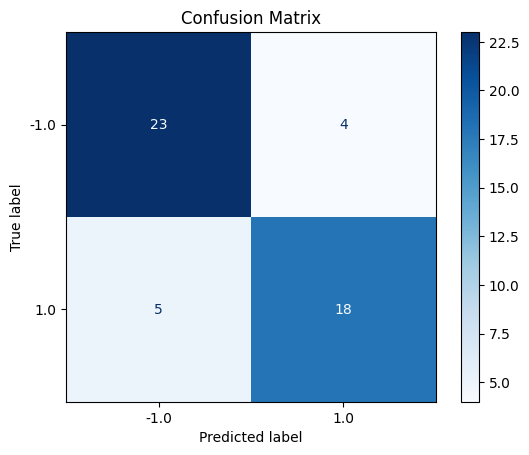

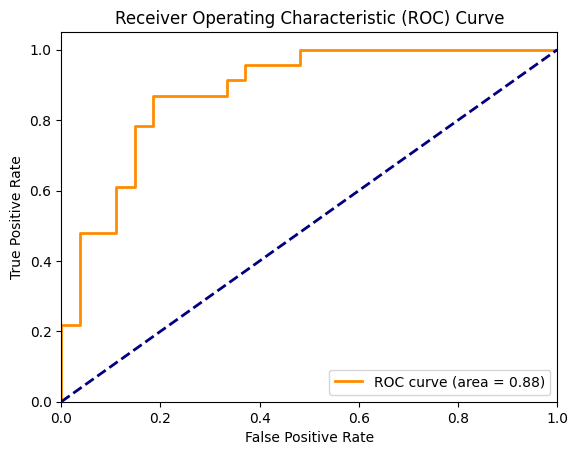

Class -1 error: 0.15
Class 1 error: 0.22


In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

logreg = LogisticRegression()

logreg.fit(X_train_csp, y_train)

y_pred = logreg.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test_csp))
roc_auc = roc_auc_score(y_test, logreg.decision_function(X_test_csp))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

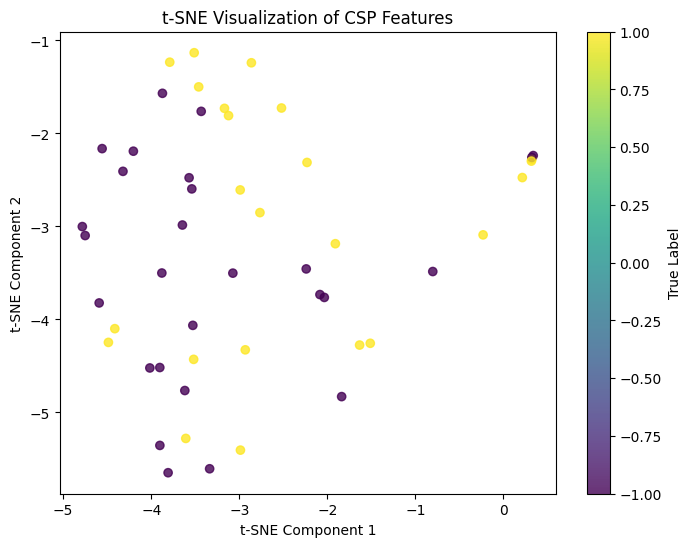

In [14]:
from sklearn.manifold import TSNE

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_csp)  # Use X_test_csp or X_train_csp here

# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.8)
plt.title('t-SNE Visualization of CSP Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='True Label')
plt.show()


**KNN**

Accuracy on test set: 0.82


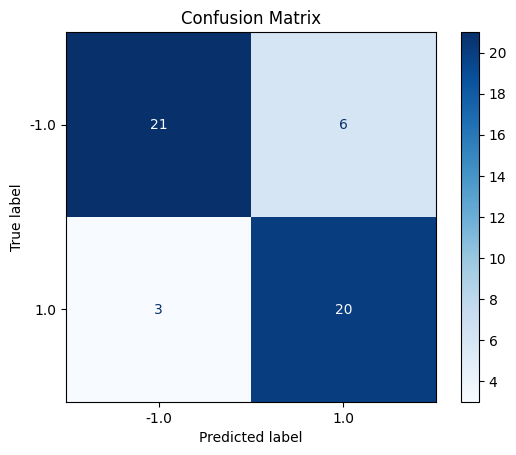

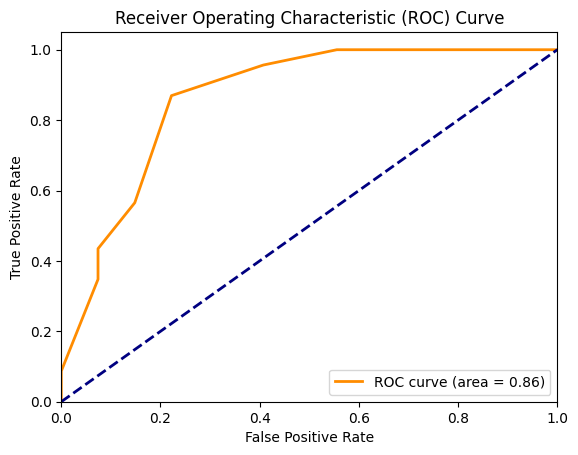

Class -1 error: 0.22
Class 1 error: 0.13


In [15]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors = 11)

knn.fit(X_train_csp, y_train)

y_pred = knn.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_csp)[:, 1])
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_csp)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**MLP**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy on test set: 0.82


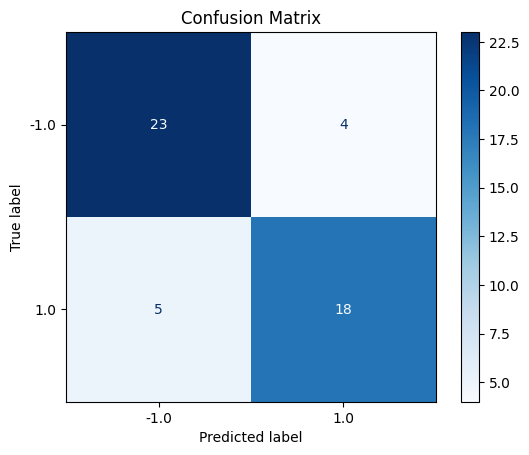

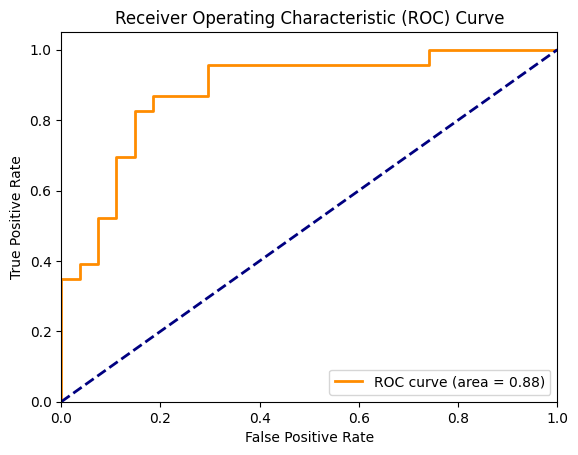

Class 0 error: nan
Class 1 error: 0.22


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

mlp = MLPClassifier(hidden_layer_sizes=(150,), max_iter=500, random_state=42)

mlp.fit(X_train_csp, y_train)

y_pred = mlp.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test_csp)[:, 1])
roc_auc = roc_auc_score(y_test, mlp.predict_proba(X_test_csp)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == 0] != y_test[y_test == 0])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class 0 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**CAR filter**

In [17]:
import numpy as np

def apply_car_filter(windows):
    num_channels = windows.shape[1]
    avg_across_channels = np.mean(windows, axis=1, keepdims=True)
    car_filtered_windows = windows - avg_across_channels
    return car_filtered_windows

car_filtered_class_0_windows = apply_car_filter(filtered_class_0_windows)

car_filtered_class_1_windows = apply_car_filter(filtered_class_1_windows)

print(f"Shape of CAR-filtered class 0 windows: {car_filtered_class_0_windows.shape}")
print(f"Shape of CAR-filtered class 1 windows: {car_filtered_class_1_windows.shape}")


Shape of CAR-filtered class 0 windows: (100, 59, 800)
Shape of CAR-filtered class 1 windows: (100, 59, 800)


**Comparing before and after filtering**

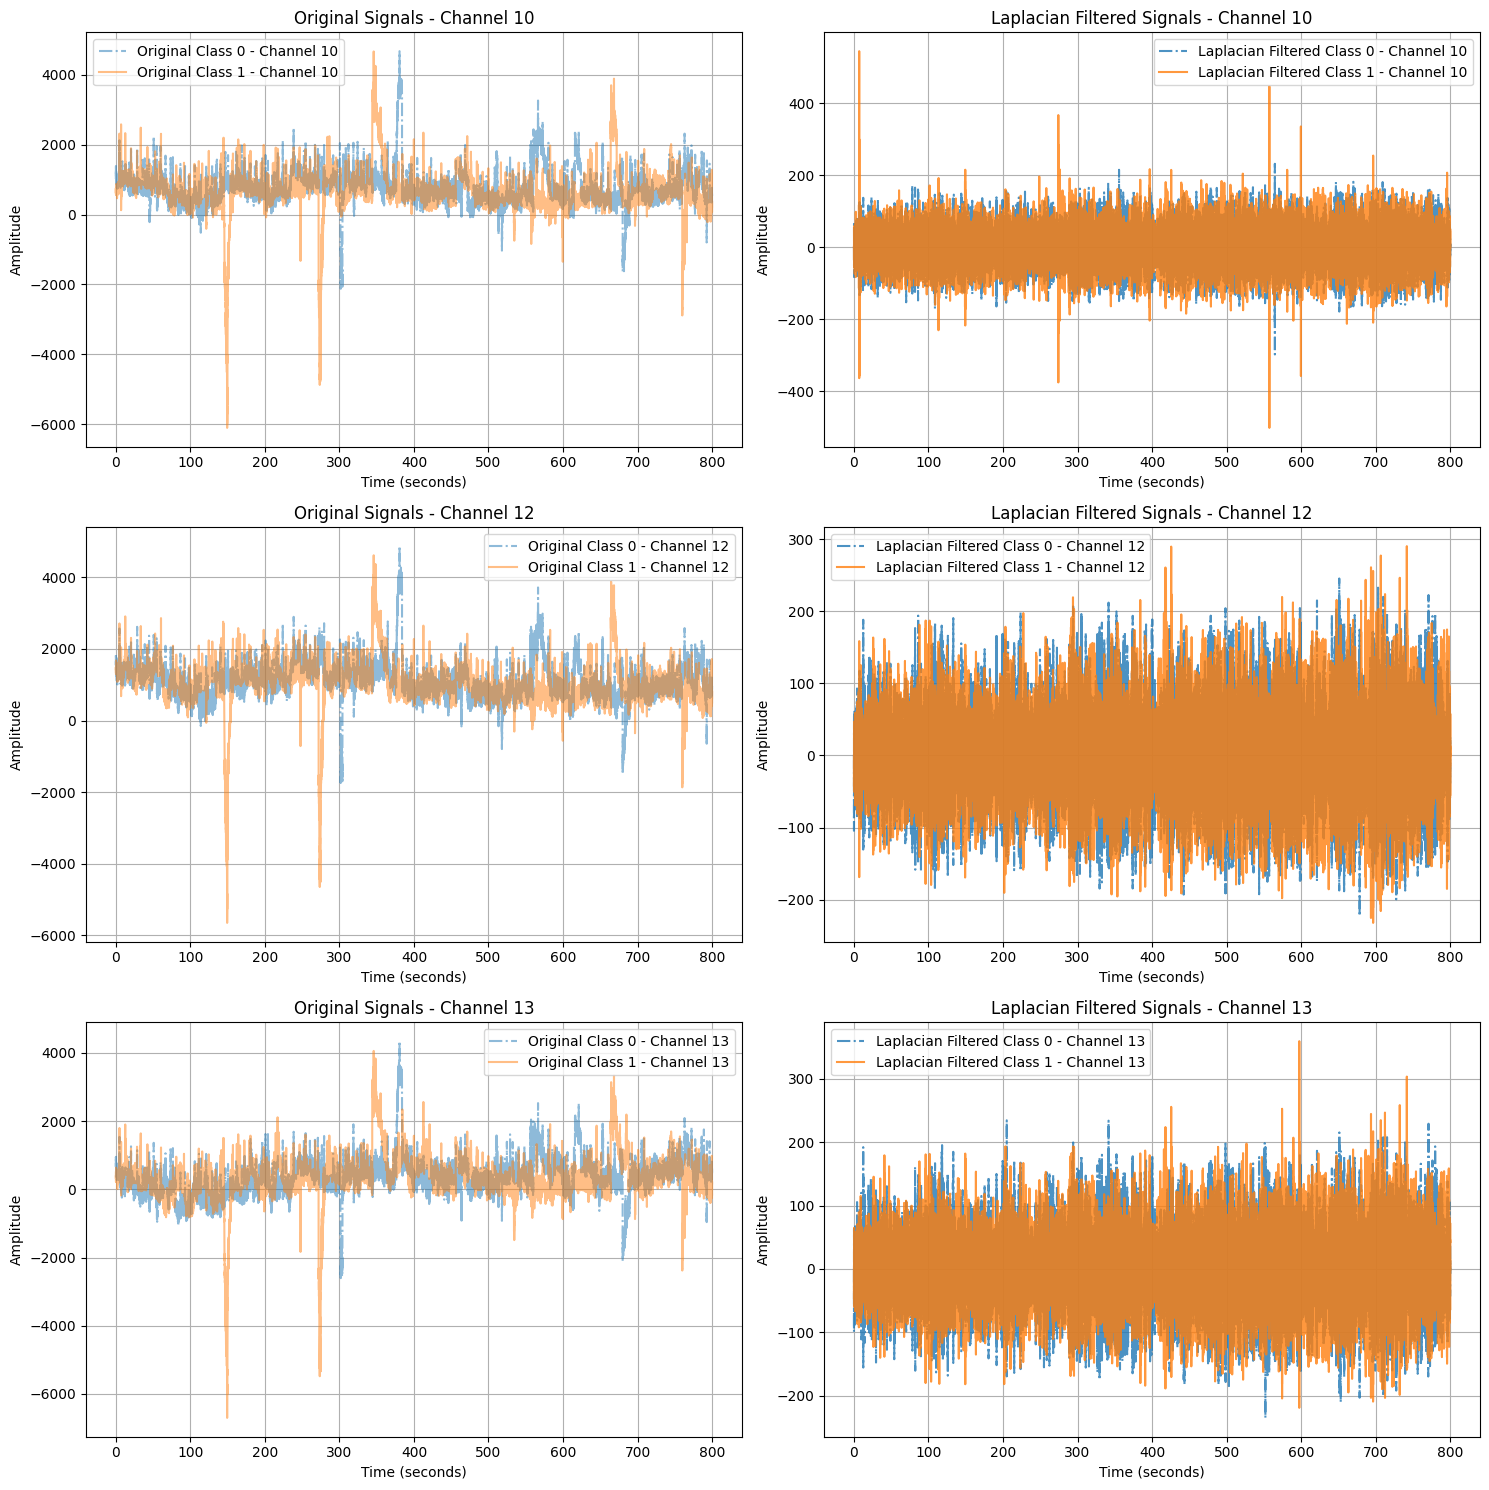

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Select channels of interest: CZ, C3, C4
channels_of_interest = [10, 12, 13]

fs = 100
window_size = 800
total_windows = 100

time = np.arange(0, total_windows * window_size) / fs

def concatenate_windows(windows, channel_index):
    return np.concatenate(windows[:, channel_index, :], axis=-1)

plt.figure(figsize=(15, 15))

for idx, channel_idx in enumerate(channels_of_interest):
    concatenated_class_0_original = concatenate_windows(class_0_windows, channel_idx)
    concatenated_class_1_original = concatenate_windows(class_1_windows, channel_idx)
    concatenated_class_0_laplacian = concatenate_windows(car_filtered_class_0_windows, channel_idx)
    concatenated_class_1_laplacian = concatenate_windows(car_filtered_class_1_windows, channel_idx)

    plt.subplot(len(channels_of_interest), 2, 2 * idx + 1)
    plt.plot(time, concatenated_class_0_original, label=f'Original Class 0 - Channel {channel_idx}', linestyle='-.', alpha=0.5)
    plt.plot(time, concatenated_class_1_original, label=f'Original Class 1 - Channel {channel_idx}', linestyle='-', alpha=0.5)
    plt.title(f'Original Signals - Channel {channel_idx}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

    plt.subplot(len(channels_of_interest), 2, 2 * idx + 2)
    plt.plot(time, concatenated_class_0_laplacian, label=f'Laplacian Filtered Class 0 - Channel {channel_idx}', linestyle='-.', alpha=0.8)
    plt.plot(time, concatenated_class_1_laplacian, label=f'Laplacian Filtered Class 1 - Channel {channel_idx}', linestyle='-', alpha=0.8)
    plt.title(f'Laplacian Filtered Signals - Channel {channel_idx}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


**t_SNE**

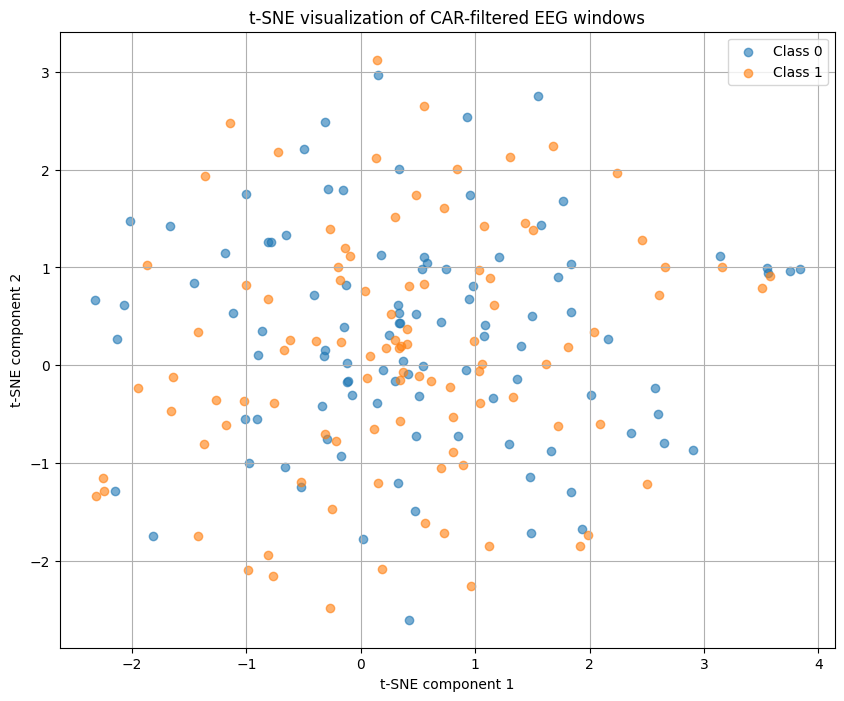

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_class_0 = car_filtered_class_0_windows.reshape(100, -1)
X_class_1 = car_filtered_class_1_windows.reshape(100, -1)

X = np.concatenate((X_class_0, X_class_1), axis=0)
y = np.concatenate((np.ones(100)*(-1), np.ones(100)))

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[y == -1, 0], X_tsne[y == -1, 1], label='Class 0', alpha=0.6)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='Class 1', alpha=0.6)
plt.title('t-SNE visualization of CAR-filtered EEG windows')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.grid(True)
plt.show()

**CSP**



In [20]:
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

class_0_data = car_filtered_class_0_windows
class_1_data = car_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

num_components = 15
csp = CSP(n_components=num_components, reg=None, log=True, norm_trace=False)

X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 1.3e+03 (2.2e-16 eps * 59 dim * 1e+17  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.


**Logistic Reggression**

Accuracy on test set: 0.86


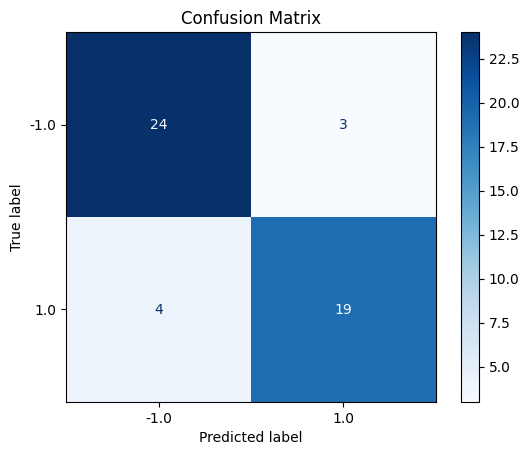

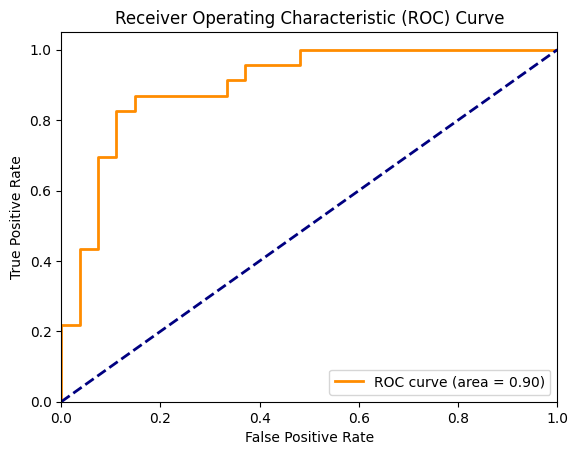

Class -1 error: 0.11
Class 1 error: 0.17


In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

logreg = LogisticRegression()

logreg.fit(X_train_csp, y_train)

y_pred = logreg.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test_csp))
roc_auc = roc_auc_score(y_test, logreg.decision_function(X_test_csp))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**KNN**

Accuracy on test set: 0.84


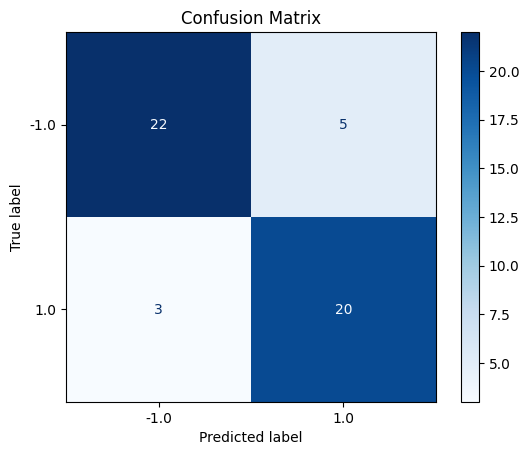

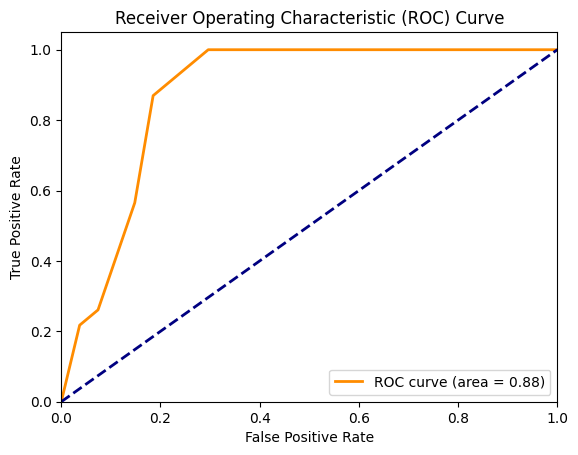

Class -1 error: 0.19
Class 1 error: 0.13


In [22]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train_csp, y_train)

y_pred = knn.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_csp)[:, 1])
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_csp)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**MLP**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy on test set: 0.82


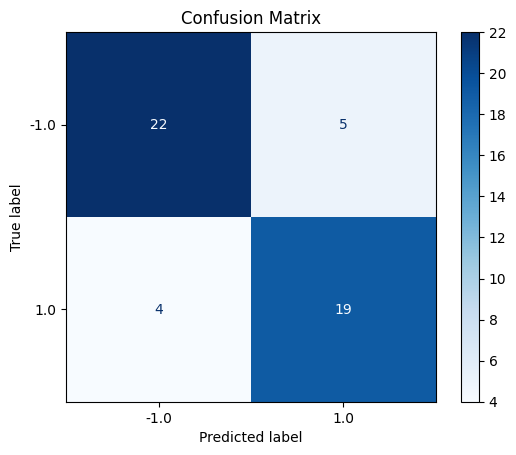

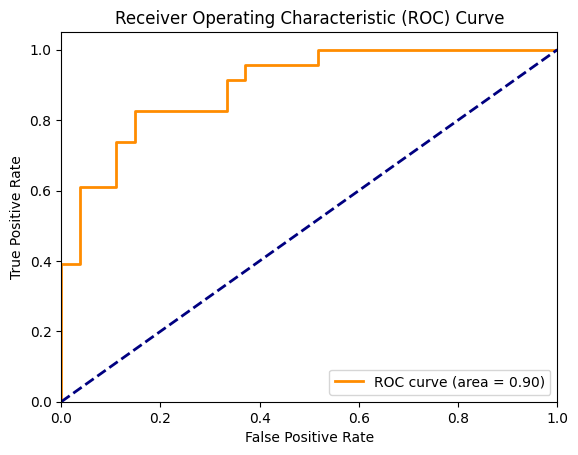

Class -1 error: 0.19
Class 1 error: 0.17


In [23]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=800, random_state=42)

mlp.fit(X_train_csp, y_train)

y_pred = mlp.predict(X_test_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test_csp)[:, 1])
roc_auc = roc_auc_score(y_test, mlp.predict_proba(X_test_csp)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**Wavelet transform and laplacian_filter**



In [24]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def extract_wavelet_features(data):
    features = []
    for trial in data:
        trial_features = []
        for channel in trial:
            coeffs = pywt.wavedec(channel, 'db4', level=4)
            trial_features.extend([np.sum(np.abs(c) ** 1) for c in coeffs])
            trial_features.extend([np.mean(c) for c in coeffs])
            trial_features.extend([np.std(c) for c in coeffs])
        features.append(trial_features)
    return np.array(features)

class_0_data = laplacian_filtered_class_0_windows
class_1_data = laplacian_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_wavelet = extract_wavelet_features(X)

X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.25, random_state=42)

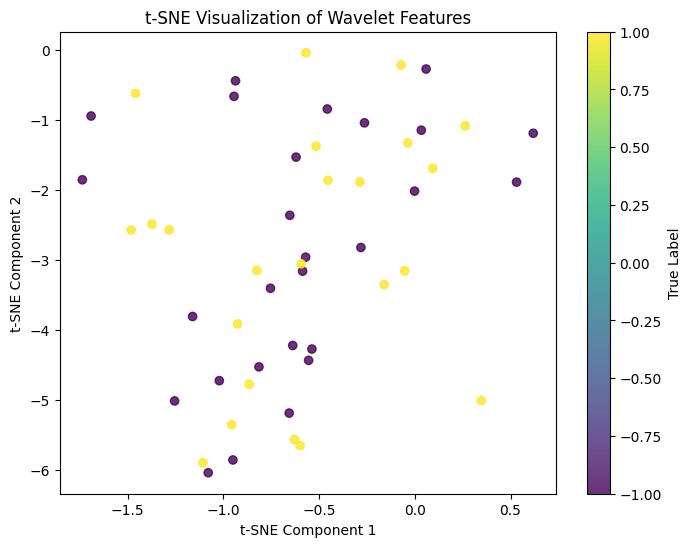

In [25]:
import numpy as np
import pywt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt


# Reshape X_train and X_test to 2D arrays
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_wavelet = tsne.fit_transform(X_test_reshaped)  # Use X_test_reshaped or X_train_reshaped here

# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne_wavelet[:, 0], X_tsne_wavelet[:, 1], c=y_test, cmap='viridis', alpha=0.8)
plt.title('t-SNE Visualization of Wavelet Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='True Label')
plt.show()


**Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test set: 0.66


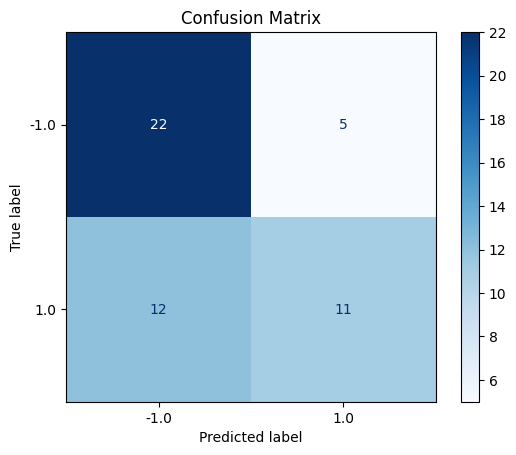

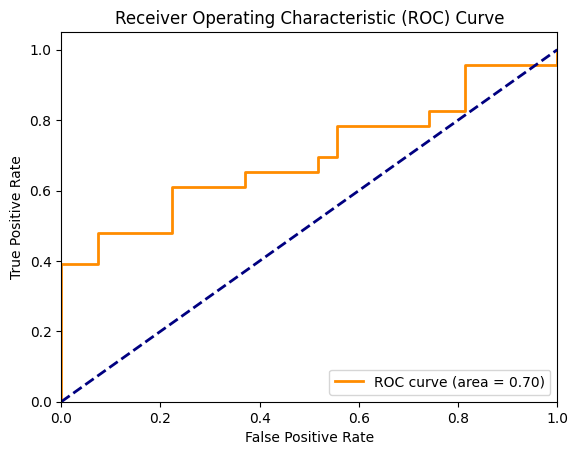

Class -1 error: 0.19
Class 1 error: 0.52


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test))
roc_auc = roc_auc_score(y_test, logreg.decision_function(X_test))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**KNN**

Accuracy on test set: 0.64


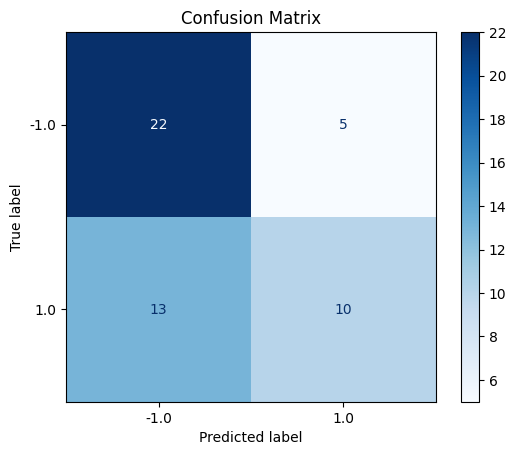

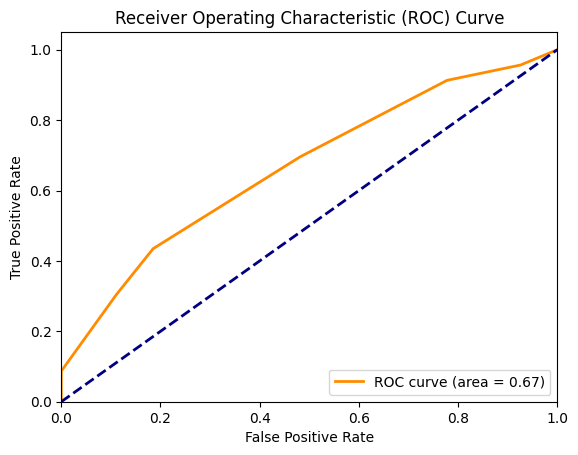

Class -1 error: 0.19
Class 1 error: 0.57


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

y_scores = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**MLP**

Accuracy on test set: 0.68


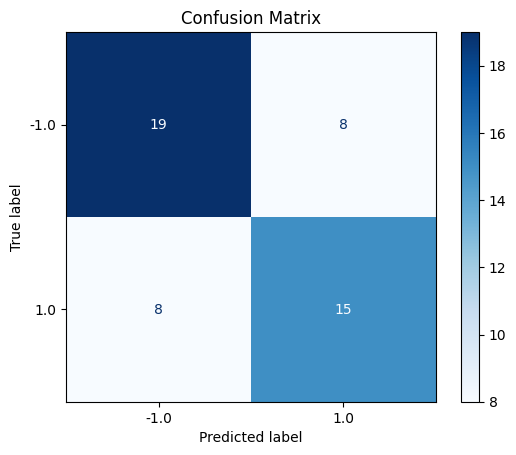

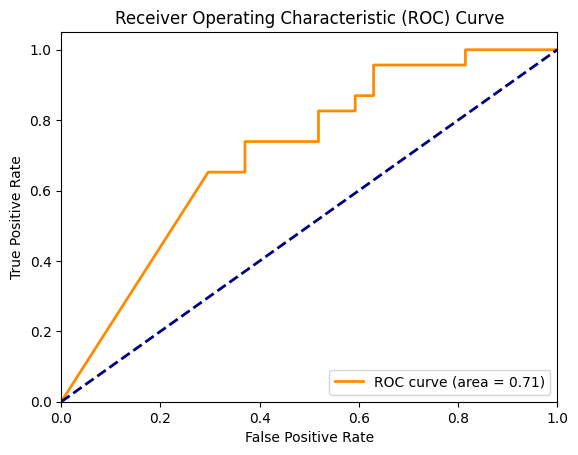

Class -1 error: 0.30
Class 1 error: 0.35


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def extract_wavelet_features(data):
    features = []
    for trial in data:
        trial_features = []
        for channel in trial:
            coeffs = pywt.wavedec(channel, 'db4', level=6)
            trial_features.extend([np.sum(np.abs(c) ** 1) for c in coeffs])
            trial_features.extend([np.mean(c) for c in coeffs])
            trial_features.extend([np.std(c) for c in coeffs])
        features.append(trial_features)
    return np.array(features)

class_0_data = laplacian_filtered_class_0_windows
class_1_data = laplacian_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_wavelet = extract_wavelet_features(X)

X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.25, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=1000, random_state=42)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

y_scores = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**Wavelet Transform and CAR_filter**

In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def extract_wavelet_features(data):
    features = []
    for trial in data:
        trial_features = []
        for channel in trial:
            coeffs = pywt.wavedec(channel, 'db4', level=5)
            trial_features.extend([np.sum(np.abs(c) ** 1) for c in coeffs])
            trial_features.extend([np.mean(c) for c in coeffs])
            trial_features.extend([np.std(c) for c in coeffs])
        features.append(trial_features)
    return np.array(features)

class_0_data = car_filtered_class_0_windows
class_1_data = car_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_wavelet = extract_wavelet_features(X)

X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.25, random_state=42)

**logistic Regression**

Accuracy on test set: 0.70


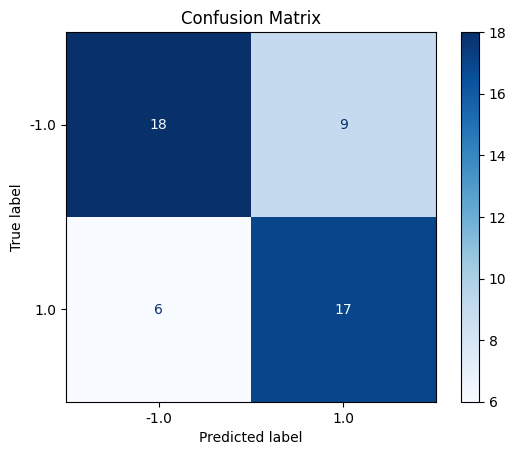

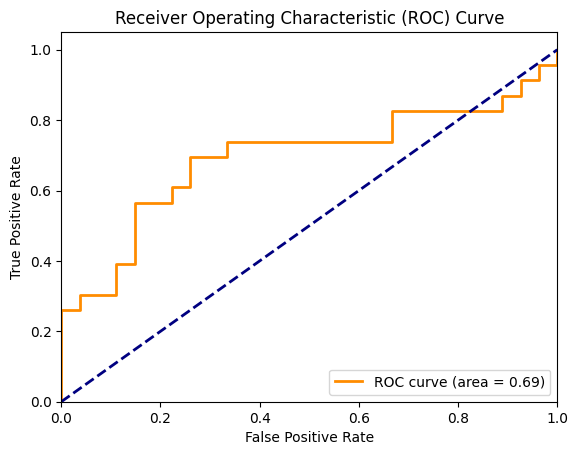

Class -1 error: 0.33
Class 1 error: 0.26


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test))
roc_auc = roc_auc_score(y_test, logreg.decision_function(X_test))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

KNN

Accuracy on test set: 0.70


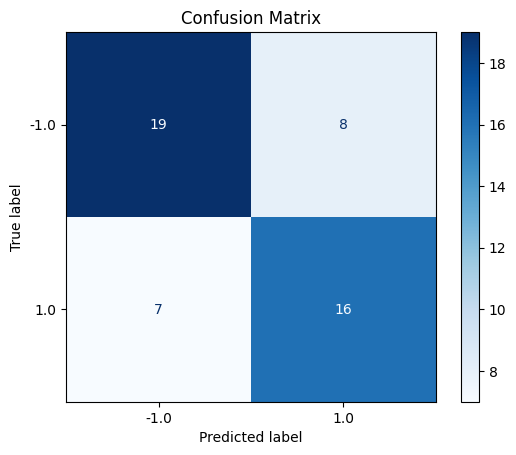

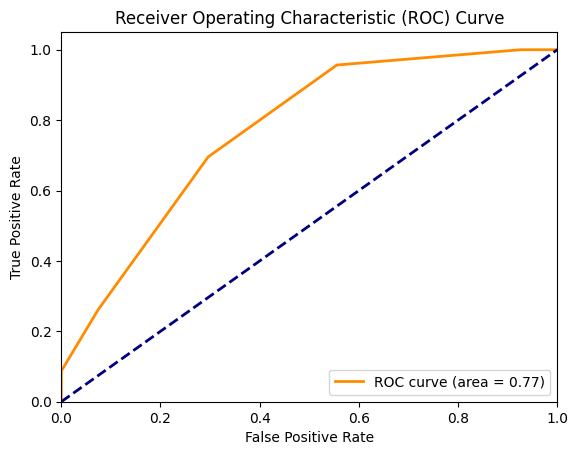

Class -1 error: 0.30
Class 1 error: 0.30


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

y_scores = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**MLP**

Accuracy on test set: 0.68


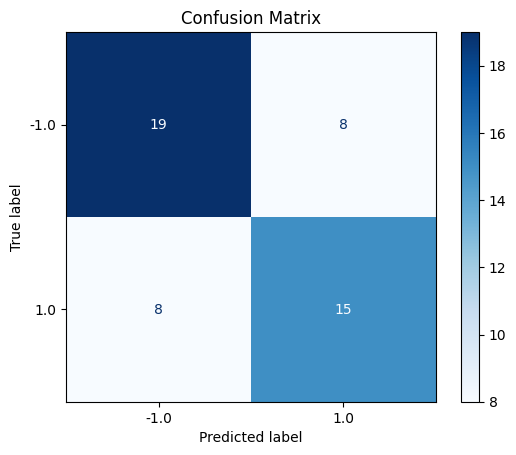

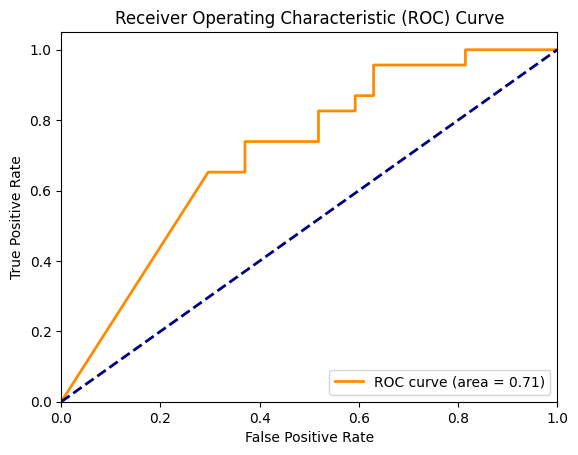

Class -1 error: 0.30
Class 1 error: 0.35


In [ ]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def extract_wavelet_features(data):
    features = []
    for trial in data:
        trial_features = []
        for channel in trial:
            coeffs = pywt.wavedec(channel, 'db4', level=6)
            trial_features.extend([np.sum(np.abs(c) ** 1) for c in coeffs])
            trial_features.extend([np.mean(c) for c in coeffs])
            trial_features.extend([np.std(c) for c in coeffs])
        features.append(trial_features)
    return np.array(features)

class_0_data = laplacian_filtered_class_0_windows
class_1_data = laplacian_filtered_class_1_windows

class_0_labels = np.ones(100)*(-1)
class_1_labels = np.ones(100)

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

X_wavelet = extract_wavelet_features(X)

X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.25, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=1000, random_state=42)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

y_scores = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

class_0_error = np.mean(y_pred[y_test == -1] != y_test[y_test == -1])
class_1_error = np.mean(y_pred[y_test == 1] != y_test[y_test == 1])

print(f"Class -1 error: {class_0_error:.2f}")
print(f"Class 1 error: {class_1_error:.2f}")

**Clustering**

GMM

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.
Purity for n_clusters = 2: 0.5300
Silhouette Score for n_clusters = 2: 0.6869
Purity for n_clusters = 3: 0.5200
Silhouette Score for n_clusters = 3: 0.4841
Purity for n_clusters = 4: 0.5200
Silhouette Score for n_clusters = 4: 0.4851
Purity for n_clusters = 5: 0.5350
Silhouette Score for n_clusters = 5: 0.2914
Purity for n_clusters = 6: 0.5550
Silhouette Score for n_clusters = 6: 0.2714
Purity for n_clusters = 7: 0.5550
Silhouette Score for n_clusters = 7: 0.2606
Purity for n_clusters = 8: 0.6850
Silhouette Score for n_clusters = 8: 0.2097
Purity for n_clusters = 9: 0.6900
Sil

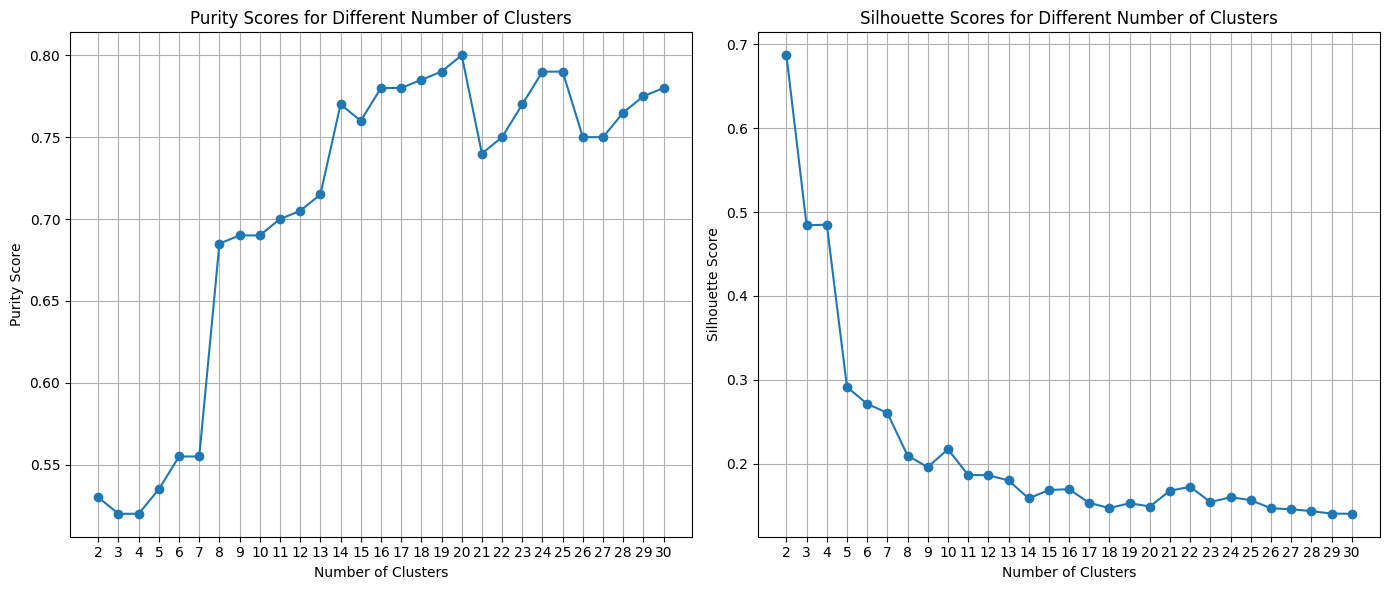

Best number of clusters based on purity: 20


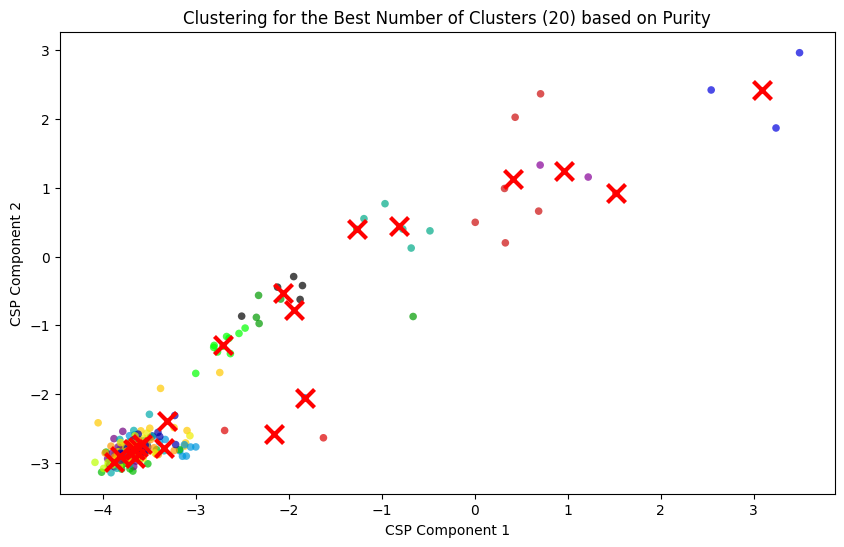

In [ ]:
import numpy as np
from mne.decoding import CSP
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(0)
class_0_data = car_filtered_class_0_windows
class_1_data = car_filtered_class_1_windows

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((np.ones(class_0_data.shape[0])*(-1), np.ones(class_1_data.shape[0])))

num_components = 15
csp = CSP(n_components=num_components, reg=None, log=True, norm_trace=False)

X_csp = csp.fit_transform(X, y)

def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((np.unique(y_true).shape[0], np.unique(y_pred).shape[0]), dtype=int)
    for i, label in enumerate(np.unique(y_true)):
        for j, cluster in enumerate(np.unique(y_pred)):
            contingency_matrix[i, j] = np.sum((y_true == label) & (y_pred == cluster))
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

range_n_clusters = range(2, 31)
purity_scores = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(X_csp)

    purity = purity_score(y, cluster_labels)
    silhouette_avg = silhouette_score(X_csp, cluster_labels)

    purity_scores.append(purity)
    silhouette_scores.append(silhouette_avg)

    print(f"Purity for n_clusters = {n_clusters}: {purity:.4f}")
    print(f"Silhouette Score for n_clusters = {n_clusters}: {silhouette_avg:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, purity_scores, marker='o')
plt.title('Purity Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Purity Score')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.tight_layout()
plt.show()

best_n_clusters_purity = range_n_clusters[np.argmax(purity_scores)]
print(f"Best number of clusters based on purity: {best_n_clusters_purity}")

gmm = GaussianMixture(n_components=best_n_clusters_purity, random_state=42)
cluster_labels = gmm.fit_predict(X_csp)

def plot_clusters(X, cluster_labels, n_clusters):
    plt.figure(figsize=(10, 6))
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    centers = gmm.means_
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=169, linewidths=3, color='red', zorder=10)
    plt.title(f"Clustering for the Best Number of Clusters ({n_clusters}) based on Purity")
    plt.xlabel("CSP Component 1")
    plt.ylabel("CSP Component 2")
    plt.show()

plot_clusters(X_csp, cluster_labels, best_n_clusters_purity)

K-Means

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=0.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.
Purity for n_clusters = 2: 0.5250
Silhouette Score for n_clusters = 2: 0.7186


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Purity for n_clusters = 3: 0.5200
Silhouette Score for n_clusters = 3: 0.4841
Purity for n_clusters = 4: 0.5200
Silhouette Score for n_clusters = 4: 0.2877
Purity for n_clusters = 5: 0.5200
Silhouette Score for n_clusters = 5: 0.2905
Purity for n_clusters = 6: 0.5300
Silhouette Score for n_clusters = 6: 0.2800
Purity for n_clusters = 7: 0.6900
Silhouette Score for n_clusters = 7: 0.2429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 8: 0.5450
Silhouette Score for n_clusters = 8: 0.2759
Purity for n_clusters = 9: 0.6000
Silhouette Score for n_clusters = 9: 0.2401
Purity for n_clusters = 10: 0.7000
Silhouette Score for n_clusters = 10: 0.2324


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 11: 0.6950
Silhouette Score for n_clusters = 11: 0.1898
Purity for n_clusters = 12: 0.7000
Silhouette Score for n_clusters = 12: 0.1895
Purity for n_clusters = 13: 0.7200
Silhouette Score for n_clusters = 13: 0.1873


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 14: 0.7600
Silhouette Score for n_clusters = 14: 0.1893
Purity for n_clusters = 15: 0.7300
Silhouette Score for n_clusters = 15: 0.1861
Purity for n_clusters = 16: 0.7350
Silhouette Score for n_clusters = 16: 0.1850


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 17: 0.7350
Silhouette Score for n_clusters = 17: 0.1877
Purity for n_clusters = 18: 0.7700
Silhouette Score for n_clusters = 18: 0.1856


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 19: 0.7350
Silhouette Score for n_clusters = 19: 0.1714
Purity for n_clusters = 20: 0.7300
Silhouette Score for n_clusters = 20: 0.1737
Purity for n_clusters = 21: 0.7650
Silhouette Score for n_clusters = 21: 0.1602


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 22: 0.7400
Silhouette Score for n_clusters = 22: 0.1787
Purity for n_clusters = 23: 0.7550
Silhouette Score for n_clusters = 23: 0.1904


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 24: 0.7750
Silhouette Score for n_clusters = 24: 0.1865
Purity for n_clusters = 25: 0.7800
Silhouette Score for n_clusters = 25: 0.1589


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 26: 0.7250
Silhouette Score for n_clusters = 26: 0.1646
Purity for n_clusters = 27: 0.7600
Silhouette Score for n_clusters = 27: 0.1459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 28: 0.7350
Silhouette Score for n_clusters = 28: 0.1510


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 29: 0.7950
Silhouette Score for n_clusters = 29: 0.1456


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for n_clusters = 30: 0.7700
Silhouette Score for n_clusters = 30: 0.1497


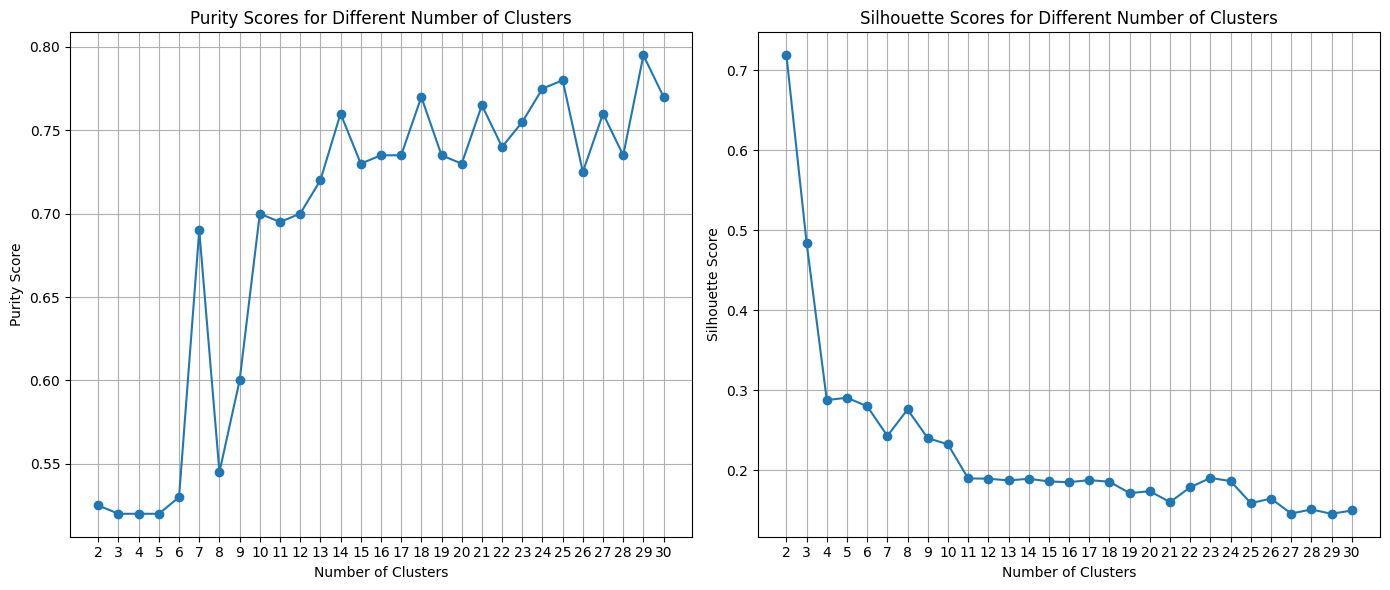

Best number of clusters based on purity: 29


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


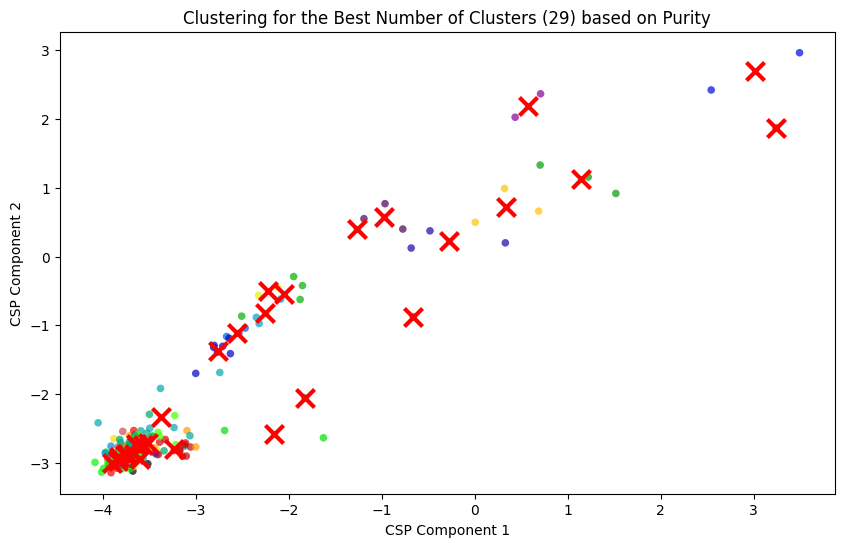

In [ ]:
import numpy as np
from mne.decoding import CSP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(0)
class_0_data = car_filtered_class_0_windows
class_1_data = car_filtered_class_1_windows

class_0_labels = np.zeros(class_0_data.shape[0])
class_1_labels = np.ones(class_1_data.shape[0])

X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels))

num_components = 15
csp = CSP(n_components=num_components, reg=None, log=True, norm_trace=False)

X_csp = csp.fit_transform(X, y)

def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((np.unique(y_true).shape[0], np.unique(y_pred).shape[0]), dtype=int)
    for i, label in enumerate(np.unique(y_true)):
        for j, cluster in enumerate(np.unique(y_pred)):
            contingency_matrix[i, j] = np.sum((y_true == label) & (y_pred == cluster))
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

range_n_clusters = range(2, 31)
purity_scores = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_csp)

    purity = purity_score(y, cluster_labels)
    silhouette_avg = silhouette_score(X_csp, cluster_labels)

    purity_scores.append(purity)
    silhouette_scores.append(silhouette_avg)

    print(f"Purity for n_clusters = {n_clusters}: {purity:.4f}")
    print(f"Silhouette Score for n_clusters = {n_clusters}: {silhouette_avg:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, purity_scores, marker='o')
plt.title('Purity Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Purity Score')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.tight_layout()
plt.show()

best_n_clusters_purity = range_n_clusters[np.argmax(purity_scores)]
print(f"Best number of clusters based on purity: {best_n_clusters_purity}")

kmeans = KMeans(n_clusters=best_n_clusters_purity, random_state=42)
cluster_labels = kmeans.fit_predict(X_csp)

def plot_clusters(X, cluster_labels, n_clusters):
    plt.figure(figsize=(10, 6))
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=169, linewidths=3, color='red', zorder=10)
    plt.title(f"Clustering for the Best Number of Clusters ({n_clusters}) based on Purity")
    plt.xlabel("CSP Component 1")
    plt.ylabel("CSP Component 2")
    plt.show()

plot_clusters(X_csp, cluster_labels, best_n_clusters_purity)